### ANOVA results for belief state partitions

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

In [4]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}

In [5]:
pref_res = io_utils.read_anova_good_units(args, "95th", "BeliefPref")
conf_res = io_utils.read_anova_good_units(args, "95th", "BeliefConf")

just_pref = pref_res[~pref_res.PseudoUnitID.isin(conf_res.PseudoUnitID)]
just_conf = conf_res[~conf_res.PseudoUnitID.isin(pref_res.PseudoUnitID)]
both = pref_res[pref_res.PseudoUnitID.isin(pref_res.PseudoUnitID)]

In [ ]:
n_just_pref = just_pref.PseudoUnitID.nunique()
n_just_conf = just_conf.PseudoUnitID.nunique()
n_both = both.PseudoUnitID.nunique()
print(f"Preference selective only: {n_just_pref} units")
print(f"Confidence selective only: {n_just_conf} units")
print(f"Selective for both {n_both} units")
print(f"Total: {n_just_pref + n_just_conf + n_both}")

Preference selective only: 153 units
Confidence selective only: 439 units
Selective for both 349 units
Total: 941


In [7]:
part_res = io_utils.read_anova_good_units(args, "95th", "BeliefPartition")
print(f"Partition selective in general: {part_res.PseudoUnitID.nunique()} units")


Partition selective in general: 607 units


### Save subpops for decoding

In [8]:
sig_path = f"/data/patrick_res/firing_rates/{args.subject}/{args.trial_event}_belief_partition_95th_units.pickle"
part_res.to_pickle(sig_path)


In [9]:
sig_path = f"/data/patrick_res/firing_rates/{args.subject}/{args.trial_event}_belief_pref_95th_units.pickle"
pref_res.to_pickle(sig_path)

In [10]:
sig_path = f"/data/patrick_res/firing_rates/{args.subject}/{args.trial_event}_belief_conf_95th_units.pickle"
conf_res.to_pickle(sig_path)

### Visualization helper:

In [10]:
def plot_psth(unit, args):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    session = int(unit_id / 100)
    beh, frs = load_data(session, args, return_merged=False)
    frs = frs[frs.PseudoUnitID == unit_id]

    order = ["Low", "High"]
    colors = ["tab:green", "tab:purple"]
    sns.lineplot(pd.merge(frs, beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="BeliefConf", palette=colors, ax=ax1)
    ax1.set_xlabel("Time to StimOnset (s)")
    ax1.set_title("Confidence")

    sub_beh = beh[beh.BeliefPartition.isin([f"High {args.feat}", f"High Not {args.feat}"])]
    order = [f"High Not {args.feat}", f"High {args.feat}"]
    colors = ["tab:blue", "tab:red"]

    sns.lineplot(pd.merge(frs, sub_beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="BeliefPartition", hue_order=order, palette=colors, ax=ax2)
    ax2.set_xlabel("Time to StimOnset (s)")    
    ax2.set_title("Preference")

    order = ["Low", f"High Not {args.feat}", f"High {args.feat}"]
    colors = ["tab:green", "tab:blue", "tab:red"]

    sns.lineplot(pd.merge(frs, beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="BeliefPartition", hue_order=order, palette=colors, ax=ax3)
    ax3.set_xlabel("Time to StimOnset (s)")
    ax3.set_title("Belief Partitions")
    fig.suptitle(f"{unit_id}, {unit.feat}, var: {unit.x_BeliefPartition_comb_time_fracvar:.3f}, {unit.structure_level2}")
    fig.tight_layout()


### Top 10 Both

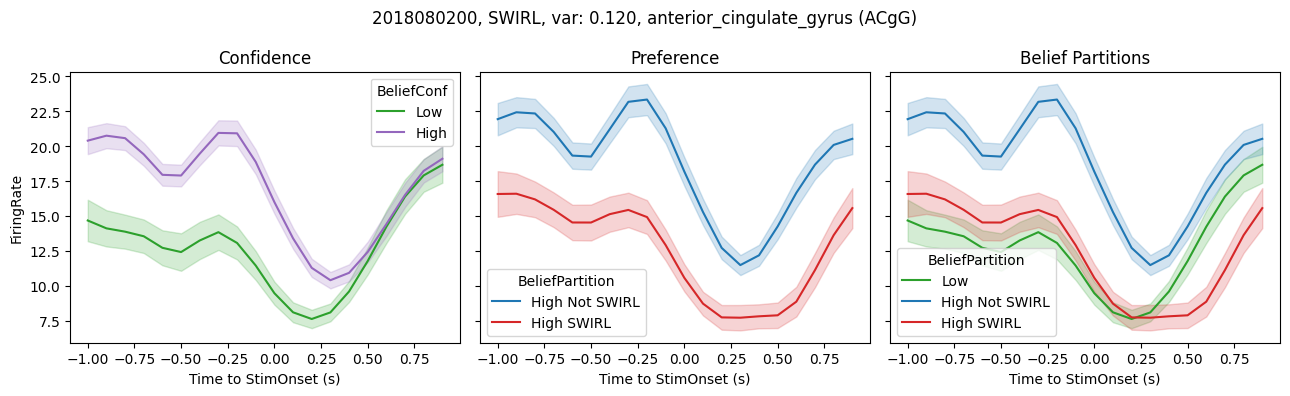

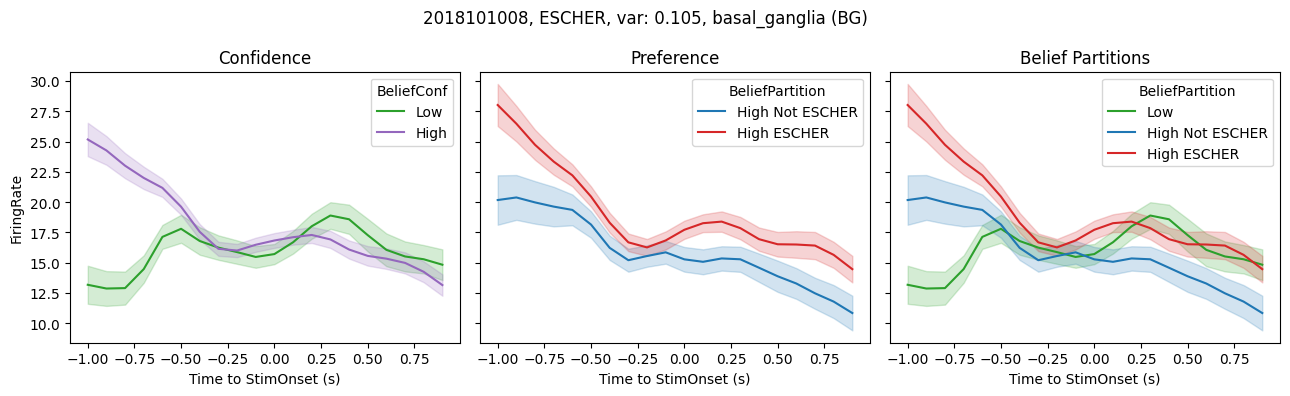

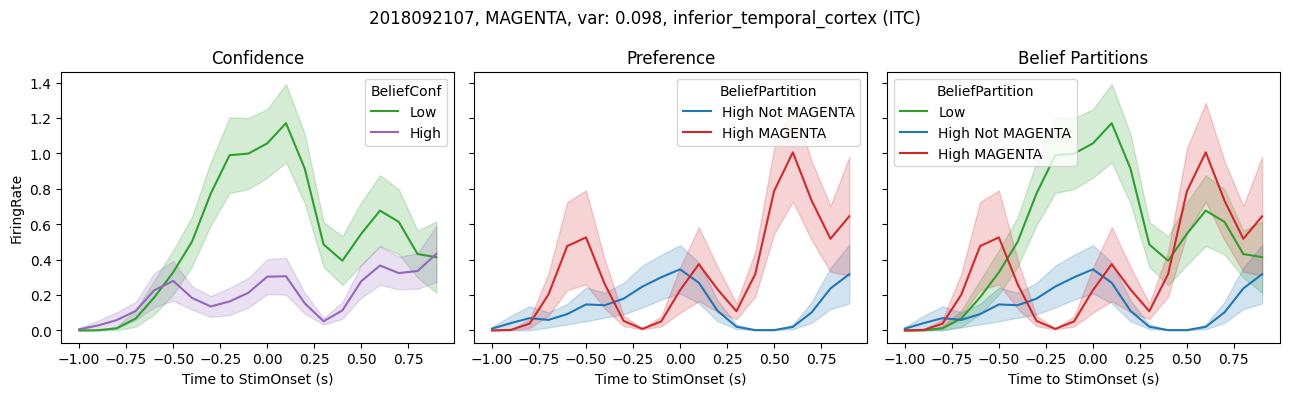

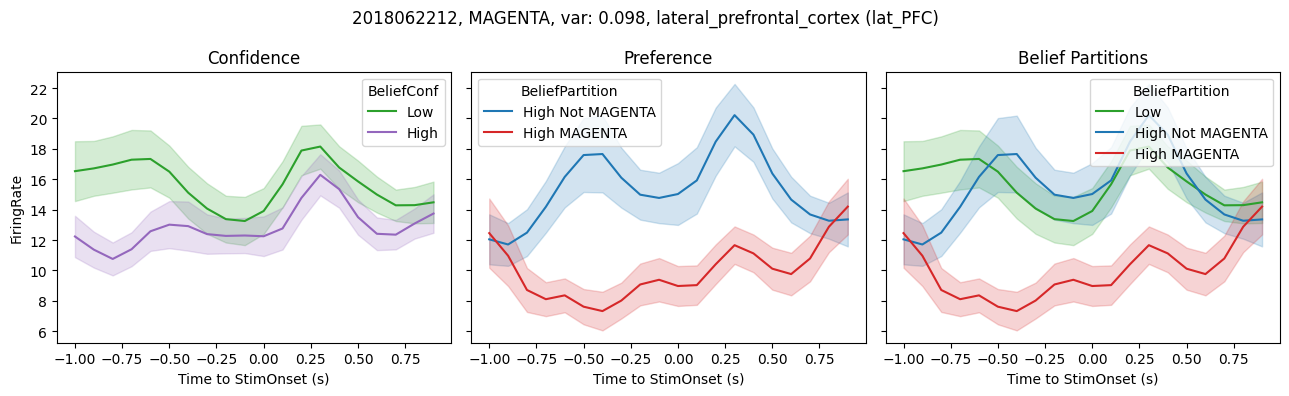

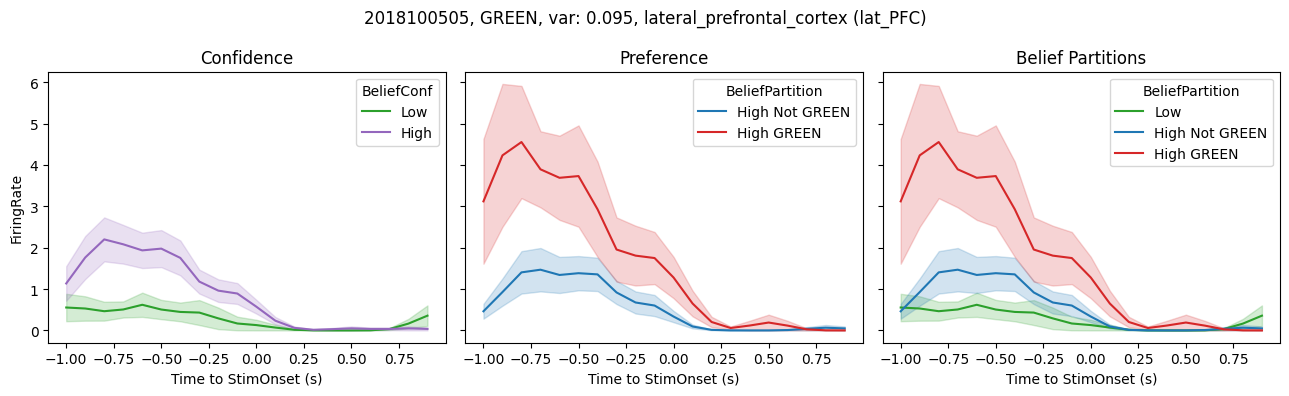

In [11]:
to_vis = both.sort_values("x_BeliefPartition_comb_time_fracvar", ascending=False)[:5]
for i, unit in to_vis.iterrows():
    plot_psth(unit, args)
    # unit_id = int(unit.PseudoUnitID)
    # args.feat = unit.feat
    # session = int(unit_id / 100)
    # beh, frs = load_data(session, args, return_merged=False)
    # frs = frs[frs.PseudoUnitID == unit_id]
    # order = np.sort(beh["BeliefPartition"].unique())


    # # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    # fig, ax = plt.subplots(figsize=(5, 4))
    # sns.lineplot(pd.merge(frs, beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="BeliefPartition", hue_order=order, ax=ax)
    # ax.set_xlabel("Time to StimOnset (s)")
    # ax.set_title(f"{unit_id}, {unit.feat}, var: {unit.x_BeliefPartition_comb_time_fracvar:.3f}, {unit.structure_level2}")

### Top 10 BeliefConf

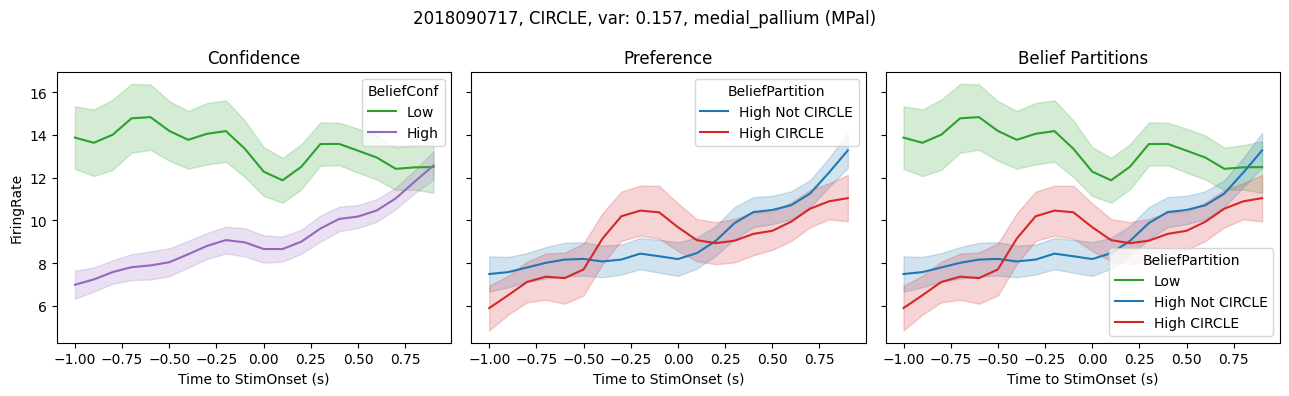

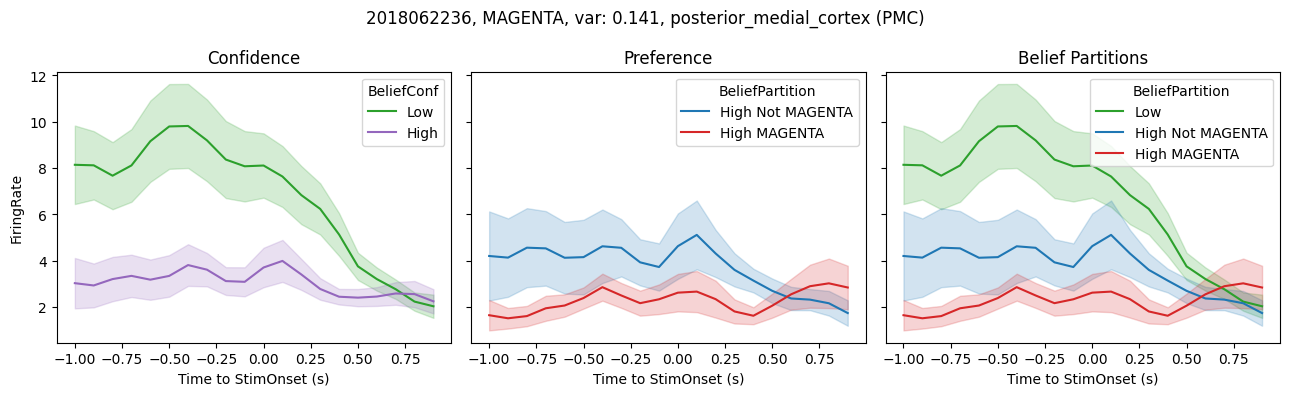

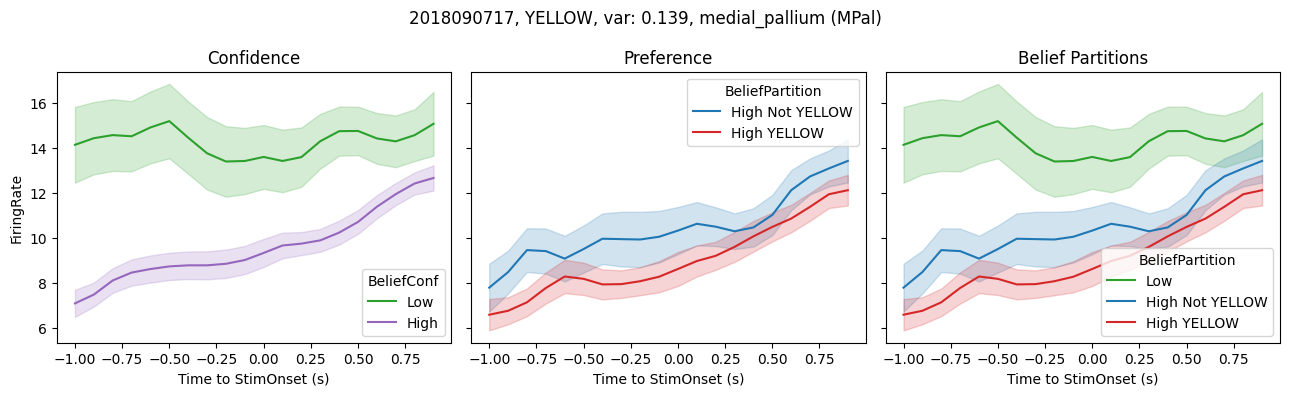

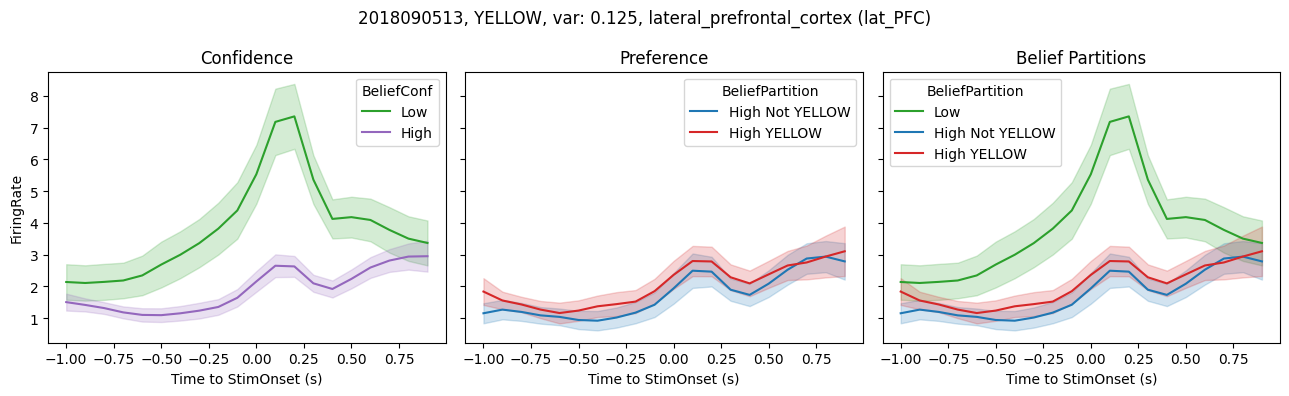

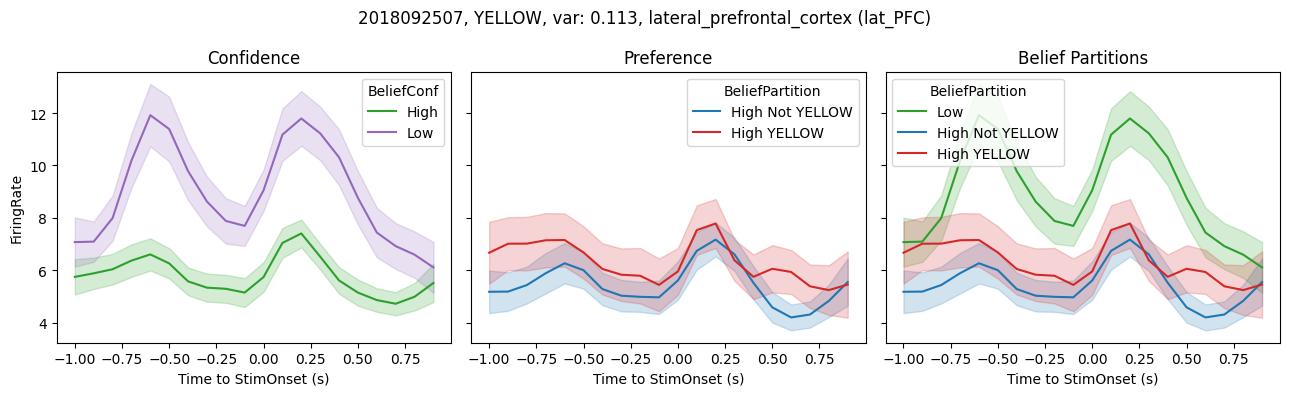

In [12]:
to_vis = just_conf.sort_values("x_BeliefConf_comb_time_fracvar", ascending=False)[:5]
for i, unit in to_vis.iterrows():
    plot_psth(unit, args)

### Top 10 BeliefPref

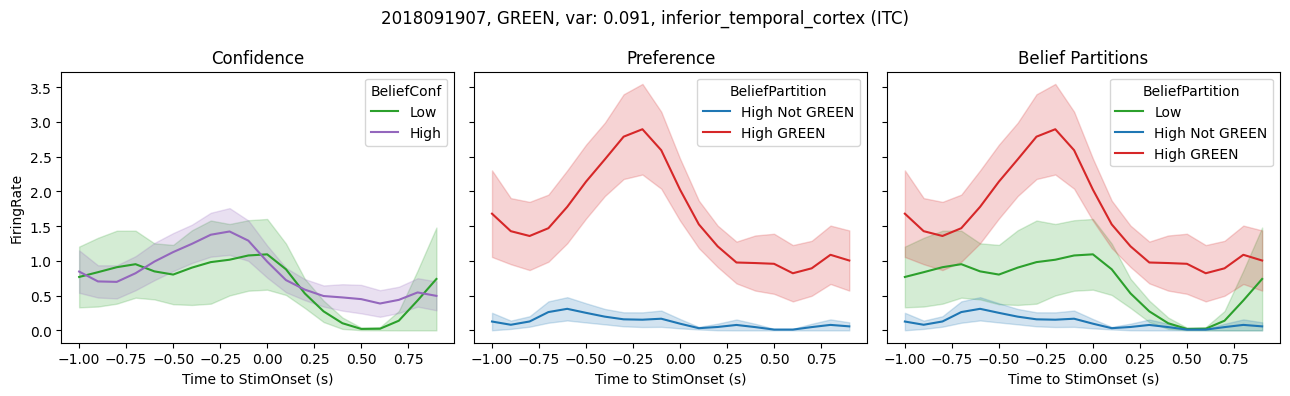

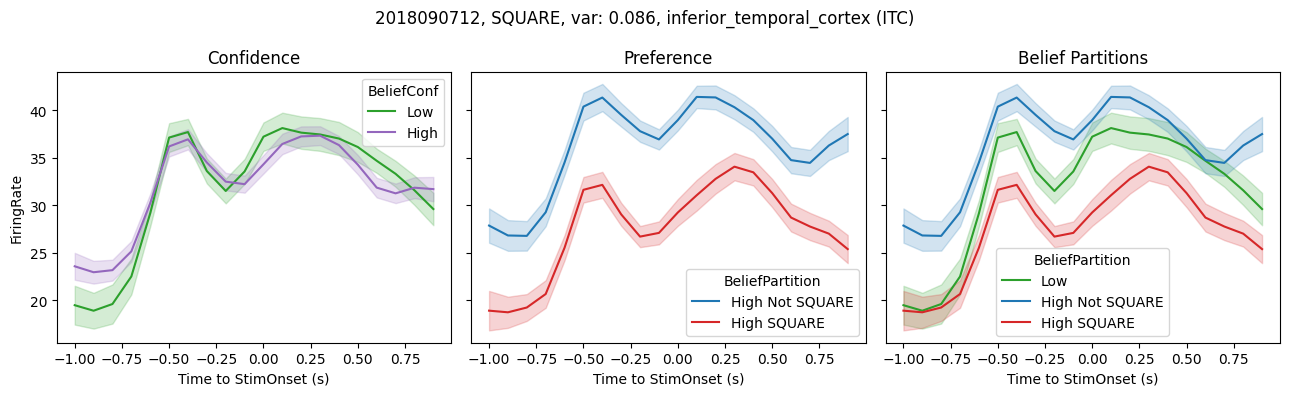

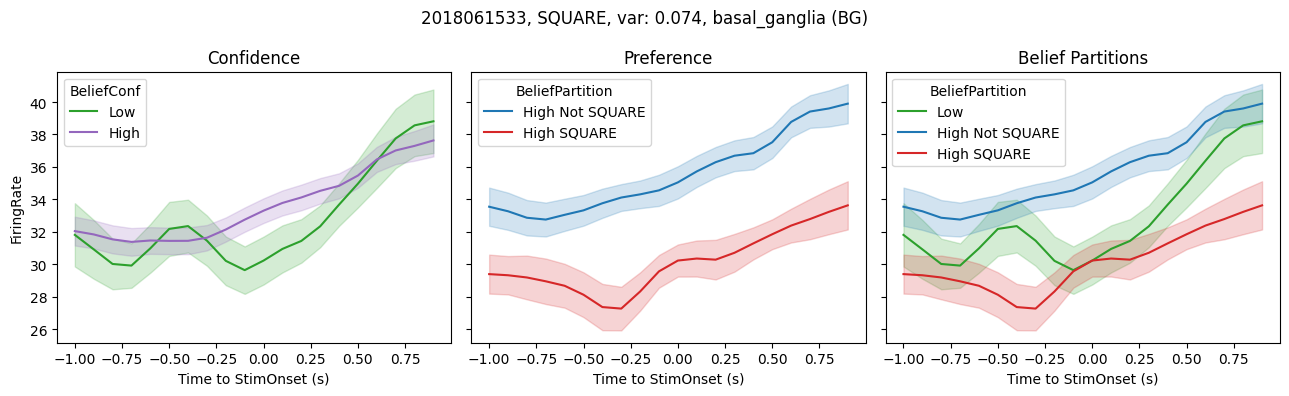

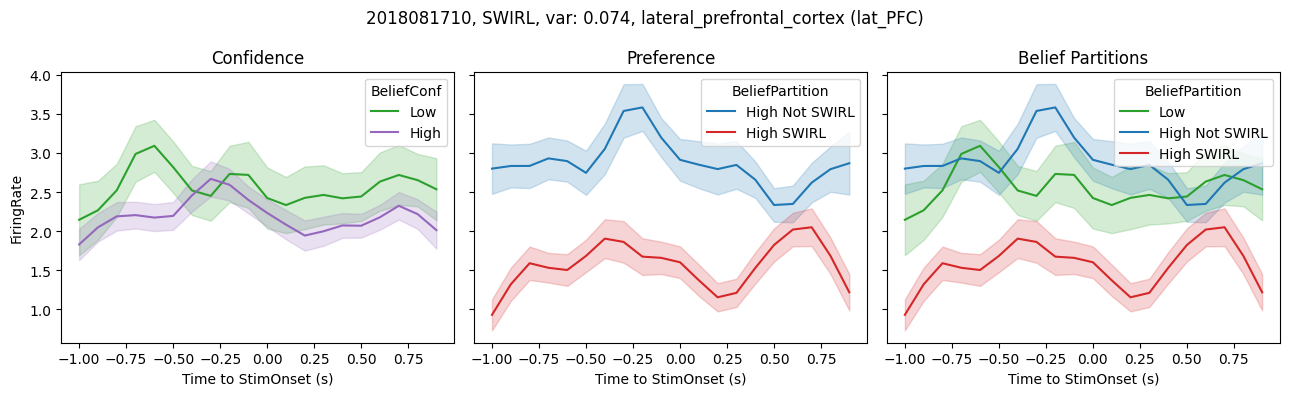

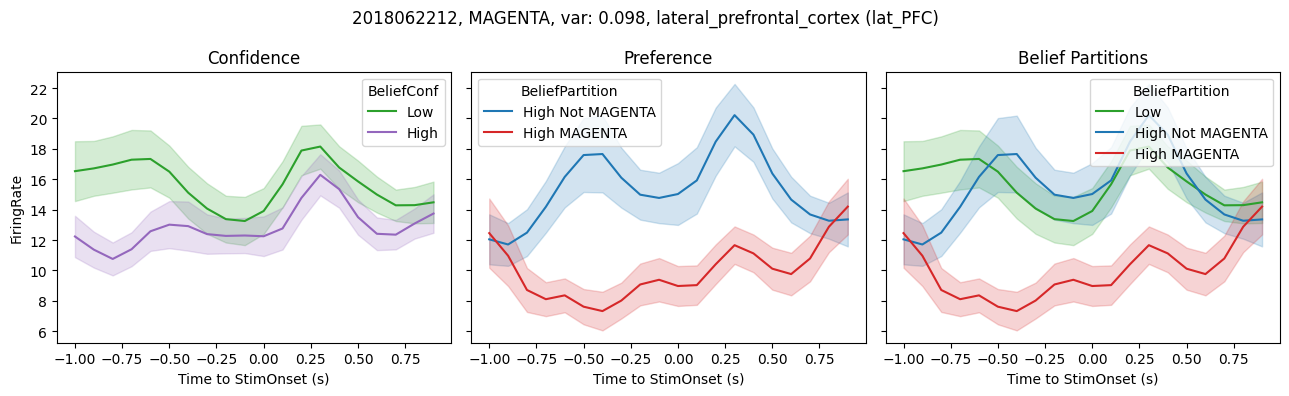

In [13]:
to_vis = just_pref.sort_values("x_BeliefPref_comb_time_fracvar", ascending=False)[:5]
for i, unit in to_vis.iterrows():
    plot_psth(unit, args)